# Erklärung Notebook
In diesem Notebook ist der Code auf dem selben Stand wie in dem Hauptscript dieses Projekts (ray_cast.py) mit den Unterschieden:
* Veranschaulicht besser die Eigenschaften der Copc Dateien
* Beinhaltet Beispiele welche im Script ausgelassen wurden (copclib)
* Visuelle Darstellungen mit Matplotlib (langsam bei großen Dateien)
* Besser geeignet um den Code nachvollziehen zu können

In [1]:
import copclib as copc
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib widget

from visuals import draw_boxes
from ray import Ray

In [2]:
# Datei Einlesen:
reader = copc.FileReader("./daten/autzen.copc.laz")

# Alternativer größerer Datensatz (~2gb, von copc Website)
# https://hobu-lidar.s3.amazonaws.com/sofi.copc.laz
# reader = copc.FileReader("C:/Users/vlasi/Downloads/sofi.copc.laz")

# Copc Info und Las Header (für konstruieren der Boxen)
config = reader.copc_config
copc_info = config.copc_info
las_header = config.las_header

# Bounding Box der Root node extrahieren: 

    # Root Voxelkey anlegen
root_key = copc.VoxelKey(0,0,0,0) # (tiefe, x, y, z)

    # Root Entry (Node) laden (ohne Punkte)
root_node = reader.FindNode(root_key)

    # Bounding Box konstruieren aus VoxelKey und Las-Header
root_box = copc.Box(root_key, las_header)
print("Root Box:\n\nxmin:{}\nxmax:{}\n\nymin:{}\nymax:{}\n\nzmin:{}\nzmax:{}".format(root_box.x_min, root_box.x_max, root_box.y_min, root_box.y_max, root_box.z_min, root_box.z_max))


Root Box:

xmin:635577.79
xmax:640233.3

ymin:848882.15
ymax:853537.66

zmin:406.14
zmax:5061.65000000001


In [3]:
# Alle Nodes auslesen und Bounding Boxen konstruieren

all_entries = reader.GetAllNodes()
boxes = []

for entry in all_entries:
    boxes.append(copc.Box(entry.key, las_header)) 

In [4]:
# Erstelle Instanz eines Strahles, Beispiele sind gegeben

# Hilfe um relativ zum globalen system leichter strahlen anlegen zu können
global_min_vector = np.array([root_box.x_min, root_box.y_min, root_box.z_min])
global_max_vector = np.array([root_box.x_max, root_box.y_max, root_box.z_max])
global_extent = global_max_vector - global_min_vector # == halfsize*2

#Strahl = Ray(np.array([640000, 855000, 5100]), np.array([-1, -2, -2]))
#Strahl = Ray(np.array([638514, 852027,   2127]), np.array([-1, -2, -2]))
#Strahl = Ray(global_min_vector+np.array([1000,-300,300]), np.array([0,1,-0.1]))

# nadir strahl
Strahl = Ray(global_min_vector+np.array([1000,1000,2000]), np.array([0, 0, -1]))

# alternativer Datensatz:
#Strahl = Ray(np.array([376600, 3.7587e6, 1300]), np.array([-1, -2, -2]))
Strahl.direction

d:\Arbeit\mee\ray.py:47: RuntimeWarning: divide by zero encountered in reciprocal
  self._inverse_direction = (value / norm)**(-1)


array([ 0.,  0., -1.])

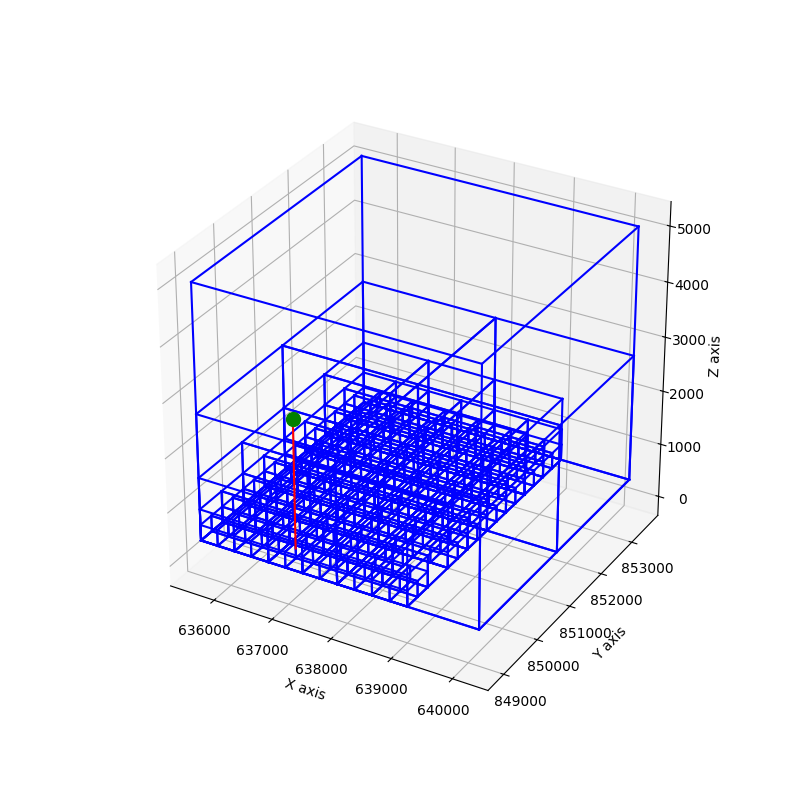

In [5]:
# Erstelle Eine Grafik mit mpl und zwei Hilfsfunktionen
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal', adjustable='box')

draw_boxes(boxes, ax)
Strahl.draw_ray(ax, Strahl.find_step_to_value(0,2))

In [6]:
# Intersection test mit allen Nodes, sehr schnell auch für größere Dateien
# 1/5 Sekunde für 13k Nodes

intersected_nodes = []
intersected_boxes = []

start = time.time()

for entry in all_entries:
    box = copc.Box(entry.key, las_header)
    if Strahl.slab_test(box):
        intersected_nodes.append(entry)
        intersected_boxes.append(box)

dauer = time.time()-start
dauer

0.0037071704864501953

In [7]:
intersected_nodes

[Entry (0, 0, 0, 0): off=67621846, size=834331, count=60956, is_valid=1,
 Entry (1, 0, 0, 0): off=68456177, size=347986, count=25700, is_valid=1,
 Entry (2, 0, 0, 0): off=64941191, size=428792, count=40949, is_valid=1,
 Entry (3, 1, 1, 0): off=52287961, size=424652, count=49201, is_valid=1,
 Entry (4, 3, 3, 0): off=7468978, size=385907, count=55999, is_valid=1]

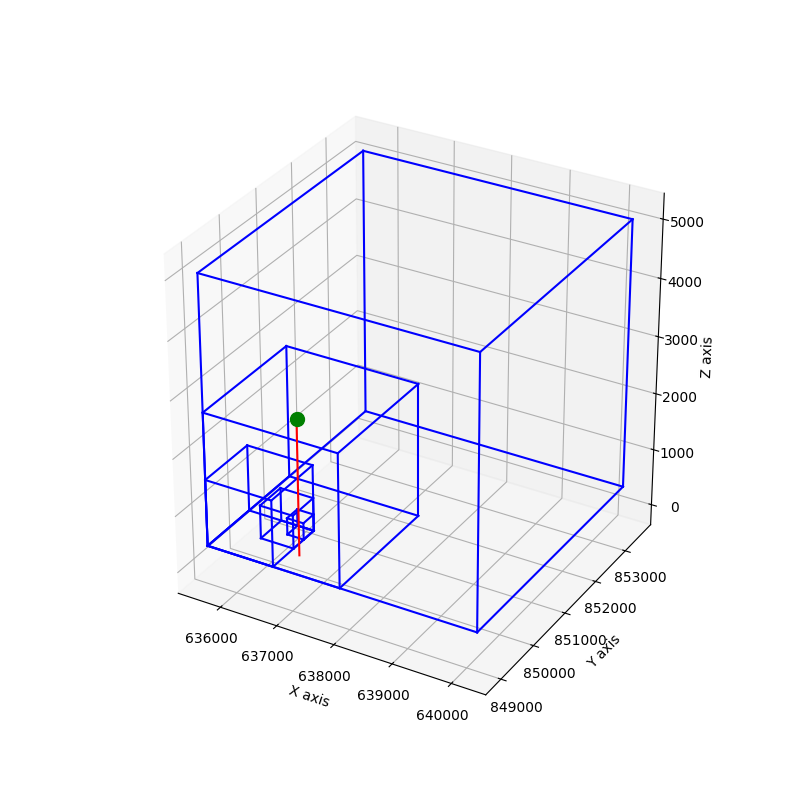

In [8]:
# Plotten der geschnittenen Nodes
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

draw_boxes(intersected_boxes, ax)
Strahl.draw_ray(ax, Strahl.find_step_to_value(0,2))

ax.set_aspect('equal', adjustable='box')

In [9]:
# Punkte aus den geschnittenen Nodes extrahieren
intersected_points_packed = []

for node in intersected_nodes:
    intersected_points_packed.append(reader.GetPoints(node))

# Beispiele für die point / points Klassen
beispielpunkt = intersected_points_packed[0][0]
beispielpunkte = intersected_points_packed[0]

In [10]:
# Punkte in ein Numpy array überführen
all_x_arrays = [points.x for points in intersected_points_packed]
all_y_arrays = [points.y for points in intersected_points_packed]
all_z_arrays = [points.z for points in intersected_points_packed]

all_x = np.concatenate(all_x_arrays)
all_y = np.concatenate(all_y_arrays)
all_z = np.concatenate(all_z_arrays)

punkte = np.column_stack((all_x, all_y, all_z))
punkte

array([[6.3887392e+05, 8.4932558e+05, 4.2490000e+02],
       [6.3886712e+05, 8.4932303e+05, 4.2497000e+02],
       [6.3886285e+05, 8.4931417e+05, 4.4531000e+02],
       ...,
       [6.3674123e+05, 8.5002525e+05, 4.4869000e+02],
       [6.3674068e+05, 8.5002320e+05, 4.4820000e+02],
       [6.3674110e+05, 8.5002299e+05, 4.4816000e+02]], shape=(232805, 3))

In [11]:
# neues koordinatensystem definieren
ursprung = Strahl.origin
x_achse = Strahl.direction

# Zufälliges "Up" array für Kreuzprodukt, überprüfen ob er zu parallel ist
up_array = np.array([0,1,0]) if abs(np.dot(x_achse, np.array([1,0,0]))) > 0.99 else np.array([1,0,0])

y_achse = np.cross(x_achse, up_array) # Kreuzprodukt steht auf beide vektoren normal
y_achse = y_achse / np.linalg.norm(y_achse) # Normalisieren

z_achse = np.cross(x_achse, y_achse)
z_achse = z_achse / np.linalg.norm(z_achse)

rotation = np.column_stack((x_achse,y_achse,z_achse))
rotation_inv = np.linalg.inv(rotation)
print(f"{rotation}\n\n")



[[ 0.  0. -1.]
 [ 0. -1. -0.]
 [-1.  0. -0.]]




In [12]:
# koordinaten transformation
def transform_coords(punkte: np.ndarray, neuer_ursprung: np.ndarray, rotation: np.ndarray):
    ergebnis = punkte - neuer_ursprung
    ergebnis = ergebnis @ rotation
    return ergebnis

punkte_transformiert = transform_coords(punkte, ursprung, rotation)

In [13]:
punkte_transformiert

array([[ 1981.24,   556.57, -2296.13],
       [ 1981.17,   559.12, -2289.33],
       [ 1960.83,   567.98, -2285.06],
       ...,
       [ 1957.45,  -143.1 ,  -163.44],
       [ 1957.94,  -141.05,  -162.89],
       [ 1957.98,  -140.84,  -163.31]], shape=(232805, 3))

In [14]:
start = time.time()

y_koordinaten = punkte_transformiert[:,1]
z_koordinaten = punkte_transformiert[:,2]

abstandsquadrate = (y_koordinaten**2) + (z_koordinaten**2)
abstandsquadrate_maske = abstandsquadrate < (10**2)
punkte_im_zylinder_lokal = punkte_transformiert[abstandsquadrate_maske]

print(time.time()-start)
len(punkte_im_zylinder_lokal)

0.0027670860290527344


213

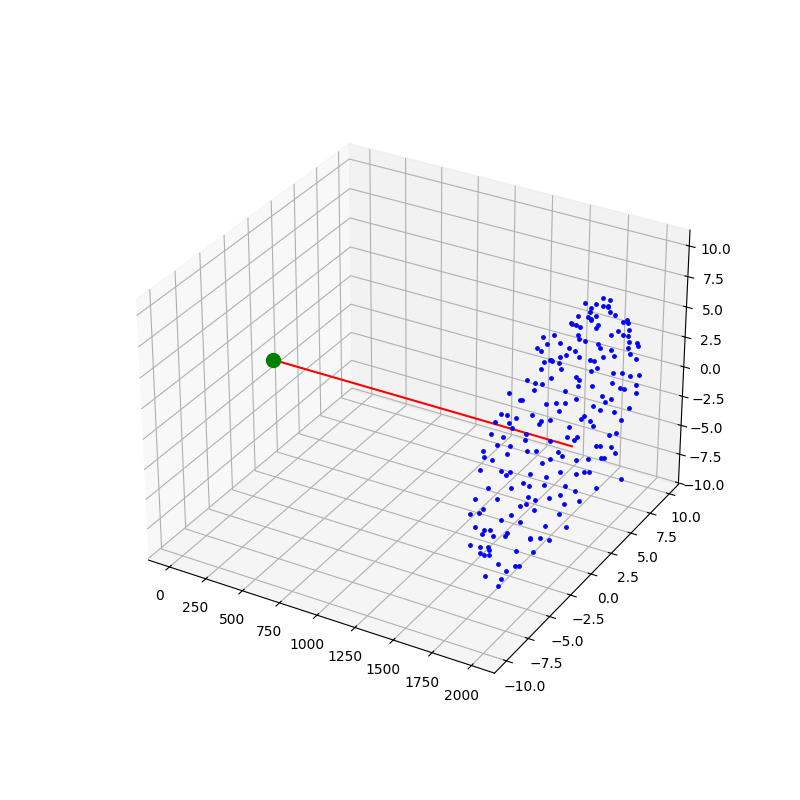

In [15]:
# Neuen Strahl im lokalen Koordinatensystem
from copy import deepcopy
Strahl2 = deepcopy(Strahl)
Strahl2.origin = np.array([0,0,0])
Strahl2.direction = transform_coords(Strahl2.direction, np.array([0,0,0]), rotation)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(1,len(punkte_im_zylinder_lokal),1): # step anpassen wenn zu langsam
    x = punkte_im_zylinder_lokal[i,:][0]
    y = punkte_im_zylinder_lokal[i,:][1]
    z = punkte_im_zylinder_lokal[i,:][2]
    ax.scatter(x,y,z, color='blue', s=6)
Strahl2.draw_ray(ax, 2000)

In [16]:
punkte_im_zylinder_global = punkte[abstandsquadrate_maske]

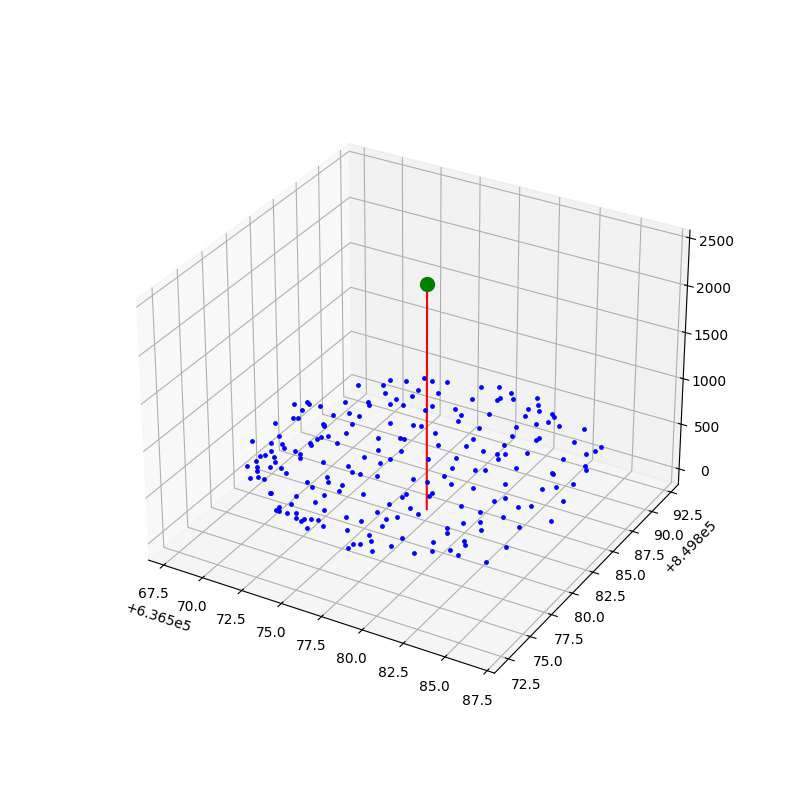

In [17]:
# Selektierten Punkte im Globalen Koordinatensystem anzeigen
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(0, len(punkte_im_zylinder_global), 1):
    x = punkte_im_zylinder_global[i,:][0]
    y = punkte_im_zylinder_global[i,:][1]
    z = punkte_im_zylinder_global[i,:][2]
    ax.scatter(x,y,z, color='blue', s=6)

Strahl.draw_ray(ax, Strahl.find_step_to_value(0,2))

In [18]:
np.savetxt("punkte.xyz", punkte_im_zylinder_global)